# Delaying flows: The Erlang kernel

Straightforward flows between compartments lead to an exponential distribution of dwell
time in a compartment. If one requires a more peaked dwell time, a solution is to model
a series of comparments with an with a faster flow between them. Consequently
the total dwell time in these compartments is more peaked. More concretely, the dwell time
distribution then follows an Erlang distribution ([wikipedia](https://en.wikipedia.org/wiki/Erlang_distribution))
with shape parameter $k$ equal to the number of 
compartments (an Erlang distribution is a gamma distribution with $k \in \mathbb{N}^+$).  
For the TLDR regarding the implementation, go to the [summary](./erlang_kernel.html#Summary) at the end. 

## Example: Erlang flow

To showcase the functioning, we implement the following system of equations. This is 
a subset of the SEIR model implemented in the [Getting started notebook](example.html). 

$$
\begin{align}
\frac{d E^{(1)}(t)}{dt} &= \text{inflow}(t) - \frac{k \cdot E^{(1)}(t)}{\tau} \\
\frac{d E^{(i)}(t)}{dt} &= \frac{k \cdot E^{(i-1)}(t)}{\tau} - \frac{k \cdot E^{(i)}(t)}{\tau} \quad \text{for } i = 2, \ldots, k \\
\frac{d T(t)}{dt} &= \frac{k \cdot T^{(k)}(t)}{\tau}
\end{align}
$$

where $E^{(i)}(t)$ are the erlang compartments, $T(t)$ is the end compartment, $k$ is 
the number of erlang compartments, and $\tau = \frac{1}{\mathrm{rate\_latent}}$ is the 
mean total dwell time in the erlang compartments. As such
the mean delay between the inflow and end compartment $T$ is equal to $\tau$. 
From an implementation perspective, one has to keep in mind that the erlang compartments 
are saved in a [jax.Array](https://docs.jax.dev/en/latest/_autosummary/jax.Array.html), increasing the number of dimensions of this series of 
compartments by 1.

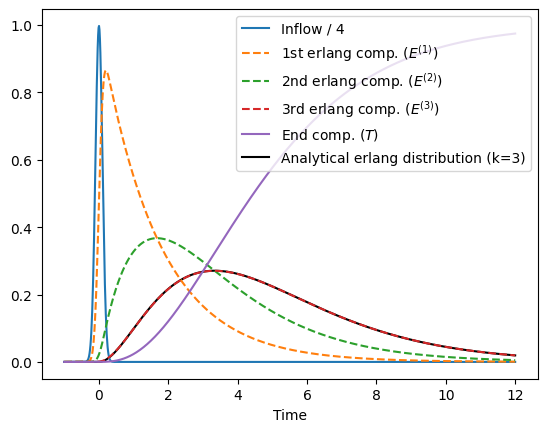

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

import icomo


# ODE: The first compartment of the Erlang compartments receives the input flow, it then
# exits the Erlang compartments with destination the end compartment.
def erlang_flow_ode(t, y, args):
    comp_model = icomo.CompModel(y)
    comp_model.add_deriv("erlang_comp", args["inflow"](t), end_comp_is_erlang=True)
    # end_comp_is_erlang=True is required to tell the model that the inflow is only
    # added to the first index of "erlang_comp".
    comp_model.erlang_flow(
        start_comp="erlang_comp",  # has shape (k,)
        end_comp="end_comp",  # has shape ()
        rate=args["rate_latent"],
    )
    return comp_model.dy


# Define an initial flow into the system: a Gaussian pulse
inflow_std = 0.1  # Standard deviation of the Gaussian pulse
inflow_pos = 0  # Position (time) of the peak of the Gaussian pulse


def inflow(t):
    return jnp.exp(-((t - inflow_pos) ** 2) / (2 * inflow_std**2)) / (
        inflow_std * jnp.sqrt(2 * jnp.pi)
    )


# Parameters for the simulation
args = {
    "inflow": inflow,
    "rate_latent": 1 / 5,  # Mean delay time of 5 time units
}

# Number of compartments in the Erlang kernel
k_erlang = 3  # Higher values reduce variance of the Erlang distribution

# Create a function that solves the ODE for arbitrary time points
erlang_flow_func = lambda t: icomo.diffeqsolve(
    ts_out=t,
    y0={
        "erlang_comp": jnp.zeros(k_erlang),  # Initial values of start compartments
        "end_comp": 0,  # Initial value of end compartment
    },
    args=args,
    ODE=erlang_flow_ode,
    # adjoint=diffrax.ForwardMode()
)

# Define the time points for the simulation
t_out = np.linspace(-1, 12, 1000)  # From t=-1 to t=12 with 1000 points

# Plot the results
plt.plot(t_out, args["inflow"](t_out) / 4, label="Inflow / 4")

plt.plot(
    t_out,
    erlang_flow_func(t_out).ys["erlang_comp"],  # has shape (t, k)
    label=[
        "1st erlang comp. ($E^{(1)}$)",
        "2nd erlang comp. ($E^{(2)}$)",
        "3rd erlang comp. ($E^{(3)}$)",
    ],
    ls="--",
)

plt.plot(
    t_out,
    erlang_flow_func(t_out).ys["end_comp"],  # has shape (t,)
    label="End comp. ($T$)",
)

# Plot the theoretical Gamma distribution for comparison
gamma_dist = lambda t: np.exp(
    pm.logp(
        pm.Gamma.dist(alpha=k_erlang, beta=args["rate_latent"] * k_erlang), value=t
    ).eval()
)
plt.plot(
    t_out,
    gamma_dist(t_out) / (k_erlang * args["rate_latent"]),  # Include normalization
    label="Analytical erlang distribution (k=3)",
    color="black",
    zorder=-3,
)

plt.legend(loc="upper right")
plt.xlabel("Time")
plt.show();

### Verification

We want to verify that (a) the compartments constantly 
sum up to one, after the influx at time 0, and that the (b) the delay between the influx
and end compartment is indeed the parametrized 5 days.

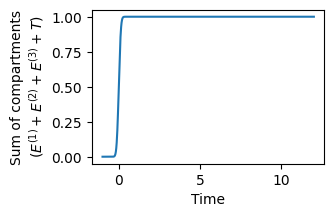

In [2]:
## Verify that the sum of compartments sums up to 1.
f = plt.figure(figsize=(3, 2))
plt.plot(
    t_out,
    sum(
        [erlang_flow_func(t_out).ys["erlang_comp"][:, i] for i in range(k_erlang)]
        + [erlang_flow_func(t_out).ys["end_comp"]]
    ),
)
plt.ylabel("Sum of compartments\n($E^{(1)} + E^{(2)} + E^{(3)} + T$)")
plt.xlabel("Time")
plt.show();

In [3]:
## Verify delay between influx and end compartment

# The influx is at time 0, therefore we only have to verify that the flow into the end
# compartment is on average at 5 days.
# As their is no outflow, we can just take the derivative of the end compartment and
# average it.

t_out = np.linspace(-1, 30, 1000)  # Longer time to get a more precise result


def f_end_comp(t):
    return erlang_flow_func(t).ys["end_comp"]


# Computing the derivative of the end compartment requires using the vjp function
# instead of jax.grad, as it is more than a scalar value.
_values, grad_fun = jax.vjp(f_end_comp, t_out)
gradients = grad_fun(jnp.ones_like(t_out))[0]

print(f"Average delay: {np.sum(gradients*t_out)/np.sum(gradients):.3f} days")

Average delay: 5.000 days


## Example: Delayed copy

One the other hand, one might want to use some values of a compartment in a delayed fashion, for 
instance a compartment might influence the flow between some other compartments but in 
a delayed manner.

To this end, we can copy the values of a compartment using the [icomo.delayed_copy](api/comp_model.rst#icomo.delayed_copy) function:
Let us implement the following set of equations, where $E^(k)$ is a delayed copy of 
$S$ by approximately $\tau$ days, more exactly, it is a convolution of $S(t)$ with a erlang kernel. 

$$
\begin{align}
\frac{d S(t)}{dt} &= \frac{d}{dt}\text{inflow}(t) \\
\frac{d E^{(1)}(t)}{dt} &= \frac{k \cdot S(t)}{\tau} - \frac{k \cdot E^{(1)}(t)}{\tau} \\
\frac{d E^{(i)}(t)}{dt} &= \frac{k \cdot E^{(i-1)}(t)}{\tau} - \frac{k \cdot E^{(i)}(t)}{\tau} \quad \text{for } i = 2, \ldots, k,
\end{align}
$$

with $S(t)$ the start compartment, $E^{(i)}(t)$ the erlang compartments, $k$ the number of erlang compartments, and $\tau = \frac{1}{\mathrm{rate\_latent}}$ the mean delay time.  As start compartment $S$ we simply reuse the gaussian pulse $\text{inflow}(t)$. 

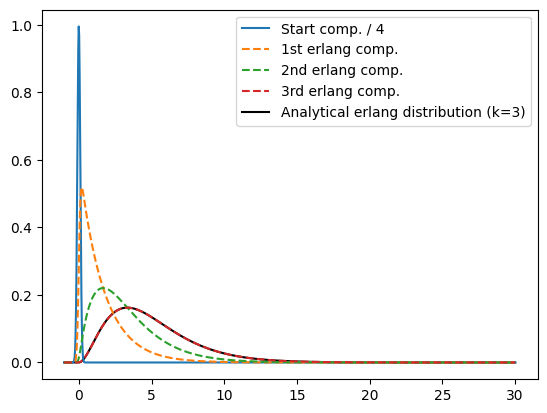

In [4]:
def delayed_copy_ode(t, y, args):
    dy = {}
    dy["start_comp"] = jax.grad(args["inflow"])(t)
    dy["erlang_comp"] = icomo.delayed_copy_kernel(
        initial_comp=y["start_comp"],
        delayed_comp=y["erlang_comp"],
        tau_delay=1 / args["rate_latent"],
    )

    return dy


# Create a function that solves the ODE for arbitrary time points
delayed_copy_func = lambda t: icomo.diffeqsolve(
    ts_out=t,
    y0={
        "start_comp": 0,  # Initial value of start compartment
        "erlang_comp": jnp.zeros(k_erlang),  # Initial values of Erlang compartments
    },
    args=args,
    ODE=delayed_copy_ode,
)


# Plot the results
plt.plot(t_out, delayed_copy_func(t_out).ys["start_comp"] / 4, label="Start comp. / 4")


plt.plot(
    t_out,
    delayed_copy_func(t_out).ys["erlang_comp"],
    label=["1st erlang comp.", "2nd erlang comp.", "3rd erlang comp."],
    ls="--",
)

# Plot the theoretical Gamma distribution for comparison
plt.plot(
    t_out,
    np.exp(
        pm.logp(
            pm.Gamma.dist(alpha=k_erlang, beta=args["rate_latent"] * k_erlang), t_out
        ).eval()
    ),
    label="Analytical erlang distribution (k=3)",
    alpha=1,
    color="black",
    zorder=-3,
)

plt.legend()
plt.show();

### Verification

We want to verify in this case, that the integral of the first start compartment, 
stays the same in the copied erlang compartment:

In [5]:
# Verify that the integral of the compartments stay constant.
t_out = np.linspace(-1, 30, 2000)
bin_width = t_out[1] - t_out[0]

integral_start_comp = np.sum(delayed_copy_func(t_out).ys["start_comp"]) * bin_width
print(f"Integral start comp.: {integral_start_comp:.3f}")

integral_erlang_comp = (
    np.sum(delayed_copy_func(t_out).ys["erlang_comp"][:, -1]) * bin_width
)
print(f"Integral last erlang comp.: {integral_erlang_comp:.3f}")

Integral start comp.: 1.000
Integral last erlang comp.: 1.000


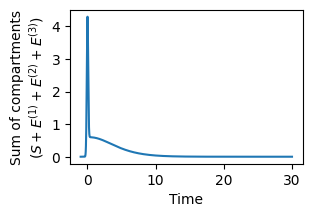

In [6]:
# As expected, contrary to the previous case, the compartments don't sum up to one.
f = plt.figure(figsize=(3, 2))
plt.plot(
    t_out,
    sum(
        [delayed_copy_func(t_out).ys["erlang_comp"][:, i] for i in range(k_erlang)]
        + [delayed_copy_func(t_out).ys["start_comp"]]
    ),
)
plt.ylabel("Sum of compartments\n($S +E^{(1)} + E^{(2)} + E^{(3)}$)")
plt.xlabel("Time")
plt.show();

## Summary

To remember: 

* Compartments that model an Erlang distribution have to augmented by a extra dimension 
added to the end.
* `comp_model.erlang_flow` expects erlang compartments at the origin/start compartment.
* `delayed_copy` expects erlang compartments at the distination/end compartment.
* If the destination compartment of a flow is used to model erlang compartments, set the 
  parameter `end_comp_is_erlang=True` to only add the flow to the first dimension. 